In [23]:
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

C:\Users\venka\anaconda3\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51251 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.0.102:51251/status,
Dashboard: http://192.168.0.102:51251/status,Workers: 1
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: False
Comm: inproc://192.168.0.102/6224/17,Workers: 1
Dashboard: http://192.168.0.102:51251/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: inproc://192.168.0.102/6224/20,Total threads: 4
Dashboard: http://192.168.0.102:51252/status,Memory: 1.86 GiB
Nanny: None,


In [2]:
import dask.array as da
x = da.random.random((10000, 10000), chunks=(1000, 1000))
x

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [3]:
y = x + x.T
z = y[::2, 5000:].mean(axis=1)
z


dask.array<mean_agg-aggregate, shape=(5000,), dtype=float64, chunksize=(500,), chunktype=numpy.ndarray>

In [4]:
z.compute()

array([1.00032659, 0.99637164, 1.00469474, ..., 0.9980733 , 0.99961973,
       1.0051993 ])

In [5]:
y = y.persist()

In [6]:
%time y[0, 0].compute()

Wall time: 812 ms


1.9565245525710788

In [7]:
import time
import random

def inc(x):
    time.sleep(random.random())
    return x + 1

def dec(x):
    time.sleep(random.random())
    return x - 1

def add(x, y):
    time.sleep(random.random())
    return x + y

In [8]:
import dask
inc = dask.delayed(inc)
dec = dask.delayed(dec)
add = dask.delayed(add)

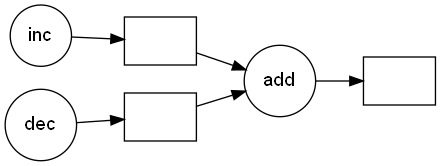

In [9]:
x = inc(1)
y = dec(2)
z = add(x, y)
z.visualize(rankdir='LR')

In [10]:
z.compute()

3

In [11]:
zs = []
zs.append(z)
zs = dask.persist(*zs)

In [12]:
client.cluster.scale(3)

In [13]:
L = zs
while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        lazy = add(L[i], L[i + 1])  # add neighbors
        new_L.append(lazy)
    L = new_L                       # swap old list for new

dask.compute(L)

((3,),)

In [19]:
future = client.submit(inc, 1)  # returns immediately with pending future
future

<Future: finished, type: dask.delayed.Delayed, key: Delayed('inc-b8784507-4fc6-4c78-877c-06856a83777d'-5981ae06e52e50362c8fbe9a4ccf2582>

In [20]:
future

<Future: finished, type: dask.delayed.Delayed, key: Delayed('inc-b8784507-4fc6-4c78-877c-06856a83777d'-5981ae06e52e50362c8fbe9a4ccf2582>

In [21]:
future.result

<bound method Future.result of <Future: finished, type: dask.delayed.Delayed, key: Delayed('inc-b8784507-4fc6-4c78-877c-06856a83777d'-5981ae06e52e50362c8fbe9a4ccf2582>>

In [24]:
future.result()

Delayed('inc-f2502220-5b5c-4e1c-8cf9-e25f5231ea18')

In [29]:
from distributed import Client
import dask_ml.datasets
import dask_ml.ensemble

X, y = dask_ml.datasets.make_classification(n_samples=1_000_000,
                                            n_informative=10,
                                            shift=2, scale=2,
                                            chunks=100_000)

In [30]:
X

dask.array<normal, shape=(1000000, 20), dtype=float64, chunksize=(100000, 20), chunktype=numpy.ndarray>

In [31]:
import sklearn.linear_model

subestimator = sklearn.linear_model.RidgeClassifier(random_state=0)
clf = dask_ml.ensemble.BlockwiseVotingClassifier(
    subestimator,
    classes=[0, 1]
)
clf

BlockwiseVotingClassifier(classes=[0, 1],
                          estimator=RidgeClassifier(random_state=0))

In [32]:
clf.fit(X, y)

In [33]:
clf.estimators_

[RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0)]

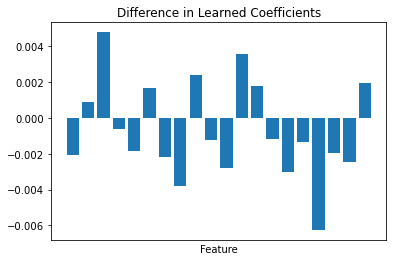

In [34]:
import matplotlib.pyplot as plt
import numpy as np

a = clf.estimators_[0].coef_
b = clf.estimators_[1].coef_


ig, ax = plt.subplots()
ax.bar(np.arange(a.shape[1]), (a - b).ravel())
ax.set(xticks=[], xlabel="Feature", title="Difference in Learned Coefficients");

In [36]:
preds = clf.predict(X)
preds
preds[:10].compute()

array([0, 0, 1, 0, 0, 0, 1, 1, 0, 1], dtype=int64)

In [37]:
X, y = dask_ml.datasets.make_regression(n_samples=1_000_000,
                                        chunks=100_000,
                                        n_features=20)
X

dask.array<normal, shape=(1000000, 20), dtype=float64, chunksize=(100000, 20), chunktype=numpy.ndarray>

In [38]:
subestimator = sklearn.linear_model.LinearRegression()
clf = dask_ml.ensemble.BlockwiseVotingRegressor(
    subestimator,
)
clf.fit(X, y)

In [39]:
clf.predict(X)[:5].compute()

array([  81.45508863, -116.84550854, -394.15064246, -303.30024482,
        -25.68391168])

In [40]:
client.restart()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.0.102:51251/status,
Dashboard: http://192.168.0.102:51251/status,Workers: 1
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: False
Comm: inproc://192.168.0.102/6224/17,Workers: 1
Dashboard: http://192.168.0.102:51251/status,Total threads: 4
Started: 41 minutes ago,Total memory: 1.86 GiB
Comm: inproc://192.168.0.102/6224/20,Total threads: 4
Dashboard: http://192.168.0.102:51252/status,Memory: 1.86 GiB
Nanny: None,
